## Cross Validation Technique Manualy-Implemented

<img src="cross-validation.png" alt="architecture info">


In [47]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
plt.style.use("dark_background")

## Cargamos los datos

In [2]:
import seaborn as sns

df_iris = sns.load_dataset("iris")

In [3]:
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Visualizamos los datos

In [4]:
#genera la distribución para todos los pares individuales de features
# sns.pairplot(df_iris, hue="species"); #indica que se muestre un color distinto para cada fila referente a una categoría concreta de especie

## Separando los datos y transformándolos a tensores de `PyTorch`

*(no usaremos devset en este caso)*

In [5]:
df_iris.iloc[:,0:4].head() #serán nuestras características, X

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [6]:
df_iris.iloc[:,-1]

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

In [29]:
from sklearn.preprocessing import LabelEncoder
#transformamos las etiquetas (y) de los datos a ser números desde 0 a n_clases-1
label_enc = LabelEncoder()

labels = label_enc.fit_transform(df_iris.species)

In [30]:
labels[4:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [31]:
proportion_train = 0.8 #80% training
n_training_samples = int(len(labels)*proportion_train)

#inincializamos un vector booleano para seleccionar los datos
train_test = np.zeros(len(labels), dtype=bool) #comienzan estando en False

train_test[(range(n_training_samples))] = True #el rango de índices correspondientes a entrenamiento serán True

In [14]:
train_test[:3]

array([ True,  True,  True])

### Como deseamos comprobar que estén de forma igualitaria distribuidas las observaciones referentes a las 3 diferentes categorías (labels) de flores iris en ambos sets, debemos ver lo siguiente:

In [19]:
labels[:3]

array([0, 0, 0])

*Si están de forma igualitaria distribuidos, la media será 1, ya que el 1 se encuentra en el medio entre 0,1, y 2. Si por ejemplo la media fuese = 0.6, significaría que tenemos más observaciones relacionadas a la categoría 0*

In [32]:
#testear si está balanceado
print("Average of entire data:")
print(torch.mean(torch.tensor(labels).float())) #debería ser 1 para estar balanceado

print("Average of training data:")
print(torch.mean(torch.tensor(labels[train_test]).float())) #debería ser 1 para estar balanceado

print("Average of test data:")
#en el contexto de nuestro vector booleano, usar el operador ~ nos devolverá lo contrario, las filas que son false (de test)
print(torch.mean(torch.tensor(labels[~train_test]).float())) #debería ser 1 para estar balanceado

Average of entire data:
tensor(1.)
Average of training data:
tensor(0.7500)
Average of test data:
tensor(2.)


In [33]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### Vemos que para todos los datos globales, están las categorías balanceadas. Sin embargo:

- ### En las observaciones referentes al `training set`, la media es 0.75, por lo que hay sobre todo etiquetas de la categoría 0

- ### En las observaciones referentes al `test set`, la media es 2, por lo que hay claramente una gran mayoría de etiquetas que son de la categoría 2

### **¿A qué se debe esto?** - A que cuando cargamos los datos, las observaciones, es decir las etiquetas venían en orden, primero observaciones de la categoría 0, después 1s, después 2s., por lo que **no estaban aleatoriamente distribuidas** 

### Barajamos aleatoriamente el vector de booleanos que nos indicaba a cada posición si la observación pertenecía o no al entrenamiento

In [39]:
np.random.shuffle(train_test)
#también usar
#items_train = np.random.choice(range(len(labels)), n_training_samples, replace=True)
#train_test[items_train] = True

In [40]:
train_test

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True, False, False, False,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
       False, False, False,  True,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False, False,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,

In [41]:
#testear si está balanceado
print("Average of entire data:")
print(torch.mean(torch.tensor(labels).float())) #debería ser 1 para estar balanceado

print("Average of training data:")
print(torch.mean(torch.tensor(labels[train_test]).float())) #debería ser 1 para estar balanceado

print("Average of test data:")
#en el contexto de nuestro vector booleano, usar el operador ~ nos devolverá lo contrario, las filas que son false (de test)
print(torch.mean(torch.tensor(labels[~train_test]).float())) #debería ser 1 para estar balanceado

Average of entire data:
tensor(1.)
Average of training data:
tensor(1.0250)
Average of test data:
tensor(0.9000)


### Ahora sí, conseguimos tener aproximadamente la media entorno a 1 en cada conjunto, dándonos a entender que está balanceado como queríamos. Cuanto más grande sea el set de datos original, menor preocupación deberemos tener por ver unas cifras exactas en el balanceo

In [44]:
X_train = torch.tensor(df_iris.iloc[:,0:4][train_test].values).float() #matriz de características
y_train = torch.tensor(labels[train_test]).long() #vector de las etiquetas transformadas a números (tipo de dato long() -> entero) #podiamos tambien haber hecho df.iris[df.iris.species=="setosa"] == 1 y así

In [92]:
X_test = torch.tensor(df_iris.iloc[:,0:4][~train_test].values).float() #matriz de características
y_test = torch.tensor(labels[~train_test]).long() 

## Creando el modelo

In [45]:
X_train.shape[1]#tenemos 4 inputs de entrada

4

In [46]:
len(y_train.unique()) #3 categorías distintas (etiquetas), 0,1 y 2 respectivamente

3

In [120]:
class Model(nn.Module):
    
    
    def __init__(self):
        super().__init__()
        
        self.input = nn.Linear(X_train.shape[1], 64) #capa de entrada (1 capa oculta de 64 nodos)
        self.hid = nn.Linear(64,64) #2da capa oculta
        self.out = nn.Linear(64,len(y_train.unique())) #capa de salida   
        
    def forward(self, x):
        
        x = F.relu(self.input(x))
        x = F.relu(self.hid(x))
        x = self.out(x)
        # la función de pérdida CrossEntropyLoss() implementa en la misma clase la función Softmax de salida
        return x

In [121]:
model = Model()

### Como vimos, no definimos explícitamente `nn.Softmax()` en la última capa, debido a que la función de pérdidas `nn.CrossEntropyLoss()` lo implementa internamente

In [122]:
loss_func = nn.CrossEntropyLoss() #ver docs (usa LogSoftmax debido a la propiedad de los logaritmos de hacer los números pequeños "más espaciados")
#por lo que añade el logaritmo a la función softmax

learning_rate = 0.01

optim = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Entrenando el modelo

In [123]:
print(X_train.shape)
print(X_test.shape)

torch.Size([120, 4])
torch.Size([30, 4])


### Recordamos que en todo el proceso de entrenamiento no se muestra en ningún momento el conjunto de test

In [124]:
n_epochs = 1000

In [125]:
losses = torch.zeros(n_epochs) #para almacenar las pérdidas para cada epoch
accuracies = [] #almacenamos la métrica de precisión en cada epoch

for epoch in tqdm(range(n_epochs)):

    #forward pass
    y_hat = model(X_train)

    #compute error
    loss = loss_func(y_hat, y_train)
    losses[epoch] = loss

    #backward pass
    optim.zero_grad() #clear previous gradients cache
    loss.backward() #compute gradients based on the error
    optim.step() #update parameters
    
    #calculamos la precisión
    #(examinamos así como cambia la precisión con el paso de las epochs)
    #ejemplo prediccion (sin softmax, valor "en bruto"): [2, 4, 3] nos da para cada clase, su probabilidad
    #obtiendo el argmax, obtenemos 0, nos da el índice, que coincide con la numeración real de categorías
    matches = torch.argmax(y_hat, axis=1) == y_train #obtenemos para cada output del modelo, el índice de la salida más alta -> categoría
    matches_num = matches.float()
    
    #la media de predicciones acertadas multiplicada por 100
    acc_pct = 100*torch.mean(matches_num)    
    accuracies.append(acc_pct)
    
# #"final forward pass" - post entrenamiento. Ahora sí usamos el test data
preds_train = model(X_train)
preds_labels = torch.argmax(preds_train, axis=1)
total_acc_train = 100*torch.mean((preds_labels == y_train).float())
print(f"Final model accuracy in train data: {total_acc_train}%")
#
preds_test = model(X_test)
preds_labels = torch.argmax(preds_test, axis=1)
total_acc_test = 100*torch.mean((preds_labels == y_test).float())
print(f"Final model accuracy in test data: {total_acc_test}%")

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1314.78it/s]

Final model accuracy in train data: 98.33333587646484%
Final model accuracy in test data: 96.66666412353516%


*En algunos casos, particularmente con pequeños sets de datos, la precisión del test set puede ser incluso mayor que la del entrenamiento*

_________

## Visualización del modelo

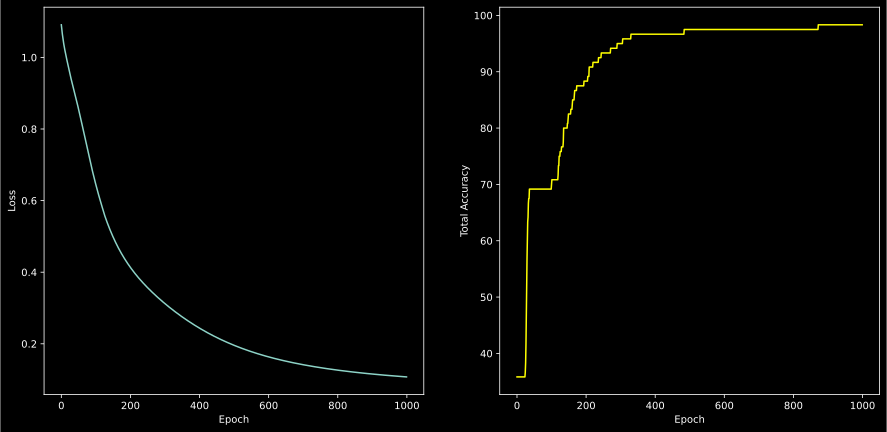

In [128]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7), sharex=True)

axs[0].plot(losses.detach()); #"o"
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")


axs[1].plot(accuracies, color="yellow");
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Total Accuracy");

_____

In [129]:
softmax_func = nn.Softmax(dim=1)

In [130]:
softmax_func(preds)[:3]

tensor([[9.9493e-01, 5.0699e-03, 5.6292e-09],
        [9.9085e-01, 9.1469e-03, 2.9679e-08],
        [9.9210e-01, 7.8989e-03, 2.5977e-08]], grad_fn=<SliceBackward0>)

In [131]:
torch.sum(softmax_func(preds), axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

____________

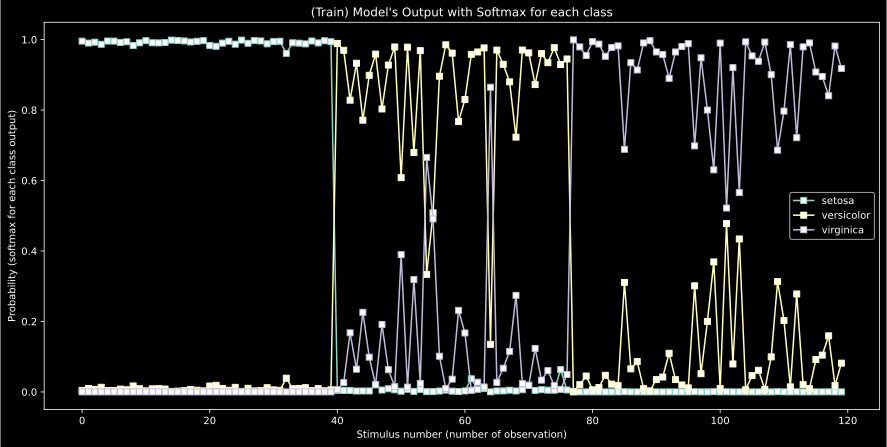

In [135]:
# plot the raw model outputs

fig = plt.figure(figsize=(15,7))
plt.title("(Train) Model's Output with Softmax for each class")
plt.plot(softmax_func(preds_train).detach(), 's-',markerfacecolor='w') #'s-',markerfacecolor='w'
plt.xlabel('Stimulus number (number of observation)')
plt.ylabel('Probability (softmax for each class output)')
plt.legend(['setosa','versicolor','virginica'])
plt.show()

# try it again without the softmax!

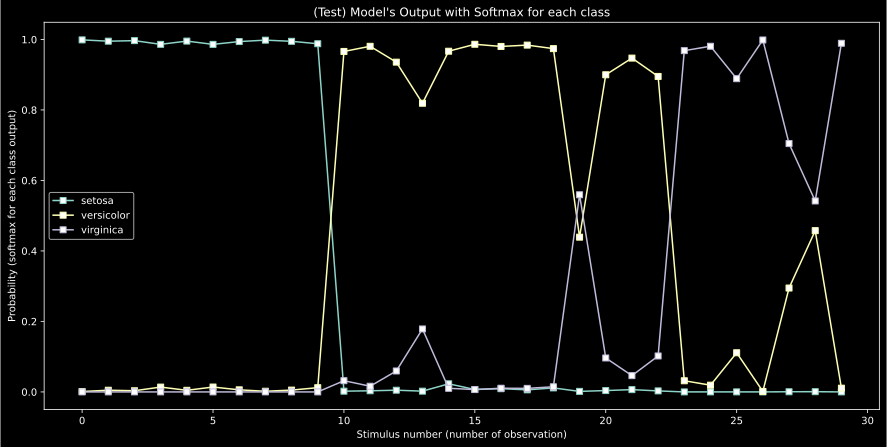

In [136]:
# plot the raw model outputs

fig = plt.figure(figsize=(15,7))
plt.title("(Test) Model's Output with Softmax for each class")
plt.plot(softmax_func(preds_test).detach(), 's-',markerfacecolor='w') #'s-',markerfacecolor='w'
plt.xlabel('Stimulus number (number of observation)')
plt.ylabel('Probability (softmax for each class output)')
plt.legend(['setosa','versicolor','virginica'])
plt.show()

# try it again without the softmax!